# Grassfire Straight Skeleton Demo

This notebook demonstrates how to use the `grassfire` package to compute the straight skeleton of polygons.

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib.pyplot as plt
from tri.delaunay.helpers import ToPointsAndSegments
from grassfire import calc_skel
import requests

import xml.etree.ElementTree as ET
from pathlib import Path

def _graphml_raw_url(url: str) -> str:
    if "github.com" in url and "/blob/" in url:
        return url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    return url


def read_graphml_polygon(source: str):
    """
    Read GraphML and return a single polygon ring as [[x,y], ...].
    Accepts a local path or URL.
    """
    if source.startswith("http://") or source.startswith("https://"):
        url = _graphml_raw_url(source)
        xml_text = requests.get(url).text
    else:
        xml_text = Path(source).read_text(encoding="utf-8")

    root = ET.fromstring(xml_text)
    ns = {"g": "http://graphml.graphdrawing.org/xmlns"}

    key_x = None
    key_y = None
    for key in root.findall("g:key", ns):
        if key.get("attr.name") == "vertex-coordinate-x":
            key_x = key.get("id")
        elif key.get("attr.name") == "vertex-coordinate-y":
            key_y = key.get("id")

    if not key_x or not key_y:
        raise ValueError("GraphML is missing vertex-coordinate-x/y keys")

    graph = root.find("g:graph", ns)
    if graph is None:
        raise ValueError("GraphML missing <graph> element")

    nodes = graph.findall("g:node", ns)

    # If node ids are numeric, sort by integer id to preserve intended order.
    ids = [n.get("id") for n in nodes]
    if ids and all(i is not None and i.isdigit() for i in ids):
        nodes = sorted(nodes, key=lambda n: int(n.get("id")))

    ring = []
    for node in nodes:
        x = y = None
        for data in node.findall("g:data", ns):
            if data.get("key") == key_x:
                x = float(data.text)
            elif data.get("key") == key_y:
                y = float(data.text)
        if x is None or y is None:
            raise ValueError(f"Node {node.get('id')} missing x/y data")
        ring.append([x, y])

    return [ring]


def plot_skeleton(poly_coords_list, title="Grassfire Straight Skeleton Demo"):
    """
    Computes and plots the straight skeleton for a list of polygon coords.
    Supports multiple rings (first ring is outer, subsequent are holes).
    """
    conv = ToPointsAndSegments()
    
    # Add points and segments for all rings
    for ring in poly_coords_list:
        # Add points
        for p in ring:
            conv.add_point(tuple(p))
        
        # Add segments
        for i in range(len(ring)):
            start = tuple(ring[i])
            end = tuple(ring[(i + 1) % len(ring)])
            conv.add_segment(start, end)

    # Calculate the skeleton
    start = time.perf_counter()
    skel = calc_skel(conv, internal_only=True)
    print(f"Skeleton calculation took: {(time.perf_counter() - start) * 1000:.2f} ms")

    # Plotting
    plt.figure(figsize=(8, 8))
    
    segments = skel.segments()
    for segment in segments:
        (start, end), infos = segment
        plt.plot([start[0], end[0]], [start[1], end[1]], color='r', linewidth=1)

    # Plot original polygon rings
    for i, ring in enumerate(poly_coords_list):
        x_poly = [p[0] for p in ring] + [ring[0][0]]
        y_poly = [p[1] for p in ring] + [ring[0][1]]
        label = "Outer Boundary" if i == 0 else f"Hole {i}"
        color = 'b-' if i == 0 else 'g-'
        plt.plot(x_poly, y_poly, color, label=label, linewidth=2)

    # Plot the skeleton segments
    plt.plot([], [], 'r--', label='Grassfire Skeleton') # For legend
    
    plt.axis('equal')
    plt.xticks([]) # Hide x axis values
    plt.yticks([]) # Hide y axis values
    
    # Position legend below the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    
    plt.title(title)
    plt.gca().invert_yaxis() # Often needed for pixel-space coordinates
    plt.show()

### 1. Simple House Shape

Skeleton calculation took: 1.42 ms


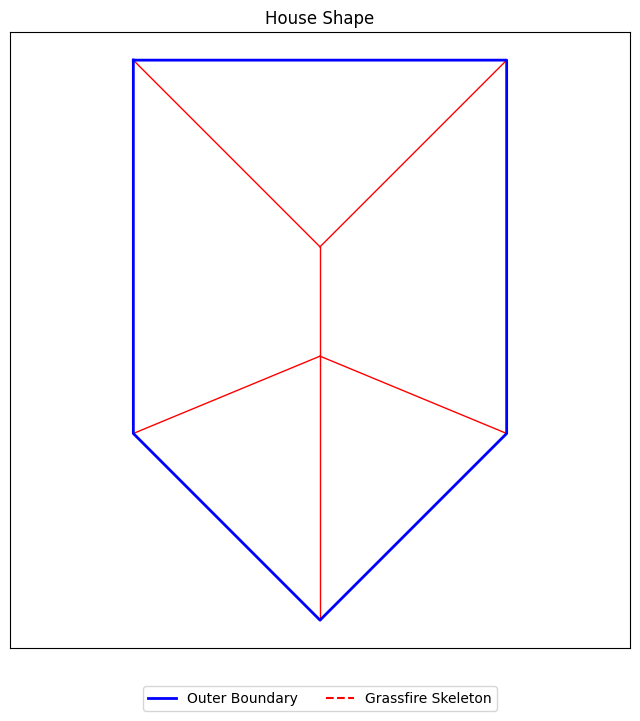

In [18]:
house = [[
    [0.0, 0.0], [10.0, 0.0], [10.0, 10.0], [5.0, 15.0], [0.0, 10.0]
]]
plot_skeleton(house, "House Shape")

### 2. L-Shaped Polygon

Skeleton calculation took: 2.06 ms


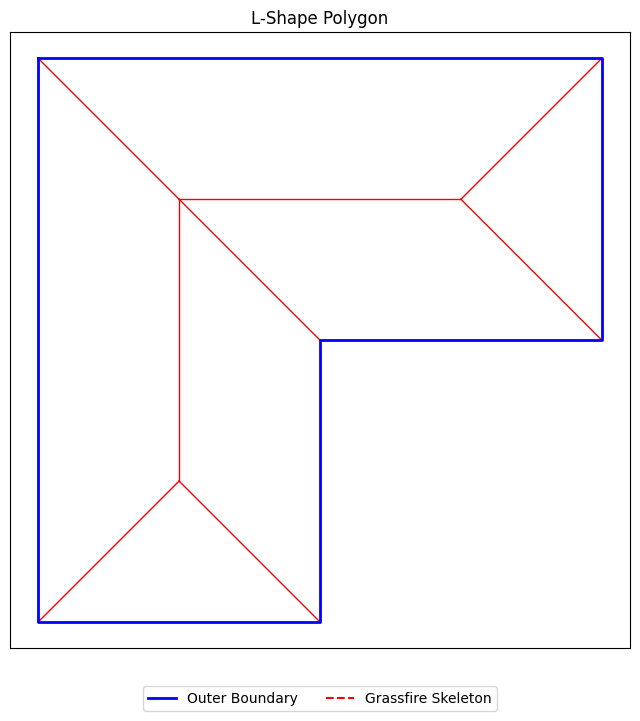

In [19]:
l_shape = [[
    [0.0, 0.0], [20.0, 0.0], [20.0, 10.0], [10.0, 10.0], [10.0, 20.0], [0.0, 20.0]
]]
plot_skeleton(l_shape, "L-Shape Polygon")

### 3. Complex Polygon from Archive

Skeleton calculation took: 205.07 ms


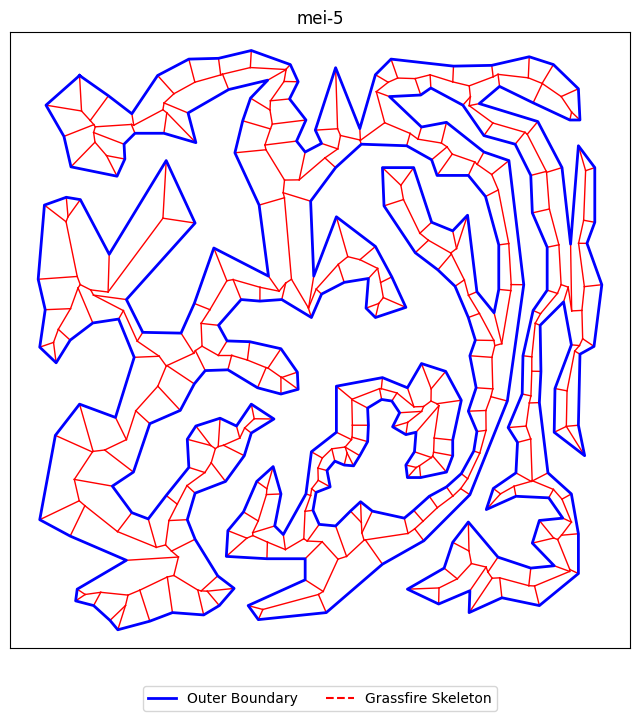

In [20]:
poly = "mei-5"
url = f"https://raw.githubusercontent.com/LingDong-/interesting-polygon-archive/master/json/{poly}.json"
eberly_coords = requests.get(url).json()

plot_skeleton(eberly_coords, f"{poly}")

### 4. Another Complex Polygon from Archive

Skeleton calculation took: 118.76 ms


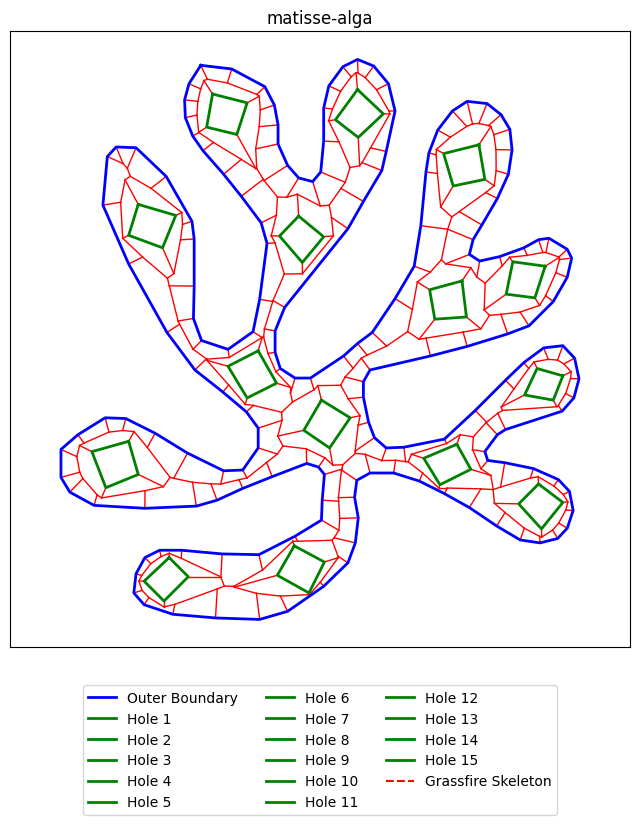

In [21]:
poly = "matisse-alga"
url = f"https://raw.githubusercontent.com/LingDong-/interesting-polygon-archive/master/json/{poly}.json"
eberly_coords = requests.get(url).json()

plot_skeleton(eberly_coords, f"{poly}")

Skeleton calculation took: 5.12 ms


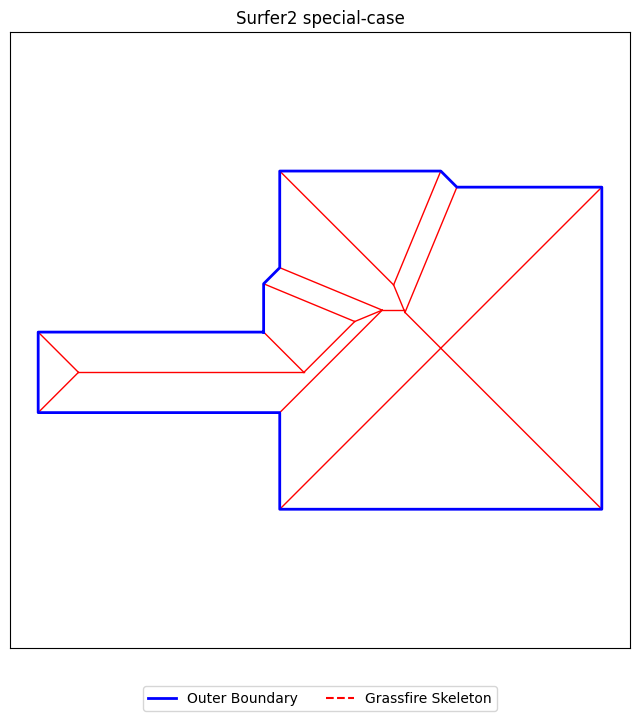

In [22]:
case = "special-cases/collinear-split-event"
case = "issue2/issue2-minimal1"
graphml_url = f"https://github.com/cgalab/surfer2/blob/master/test-data/{case}.graphml"
graphml_coords = read_graphml_polygon(graphml_url)
plot_skeleton(graphml_coords, "Surfer2 special-case")